Using device: cuda
Starting PINN training for Biharmonic Problem P4...
Starting Adam optimization...
Epoch 0: Loss = 2.87e+00 (Int: 1.29e+00, BC: 1.58e+00)
Epoch 500: Loss = 7.17e-03 (Int: 1.75e-03, BC: 5.41e-03)
Epoch 1000: Loss = 5.72e-04 (Int: 3.10e-04, BC: 2.63e-04)
Epoch 1500: Loss = 2.77e-04 (Int: 1.58e-04, BC: 1.18e-04)
Epoch 2000: Loss = 1.23e-04 (Int: 7.55e-05, BC: 4.73e-05)
Epoch 2500: Loss = 2.11e-04 (Int: 1.60e-04, BC: 5.07e-05)
Epoch 3000: Loss = 4.79e-04 (Int: 4.26e-04, BC: 5.27e-05)
Epoch 3500: Loss = 5.64e-05 (Int: 3.61e-05, BC: 2.04e-05)
Epoch 4000: Loss = 1.00e-04 (Int: 6.70e-05, BC: 3.34e-05)
Epoch 4500: Loss = 5.45e-05 (Int: 3.37e-05, BC: 2.08e-05)
Epoch 5000: Loss = 5.47e-05 (Int: 4.11e-05, BC: 1.36e-05)
Epoch 5500: Loss = 4.92e-05 (Int: 3.69e-05, BC: 1.23e-05)
Epoch 6000: Loss = 2.62e-04 (Int: 2.38e-04, BC: 2.37e-05)
Epoch 6500: Loss = 5.91e-04 (Int: 5.42e-04, BC: 4.90e-05)
Epoch 7000: Loss = 6.97e-04 (Int: 5.91e-04, BC: 1.06e-04)
Epoch 7500: Loss = 4.11e-03 (Int:

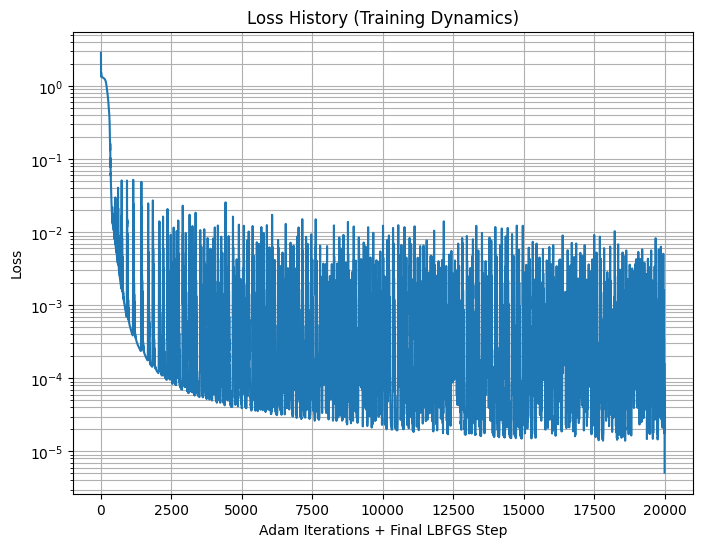

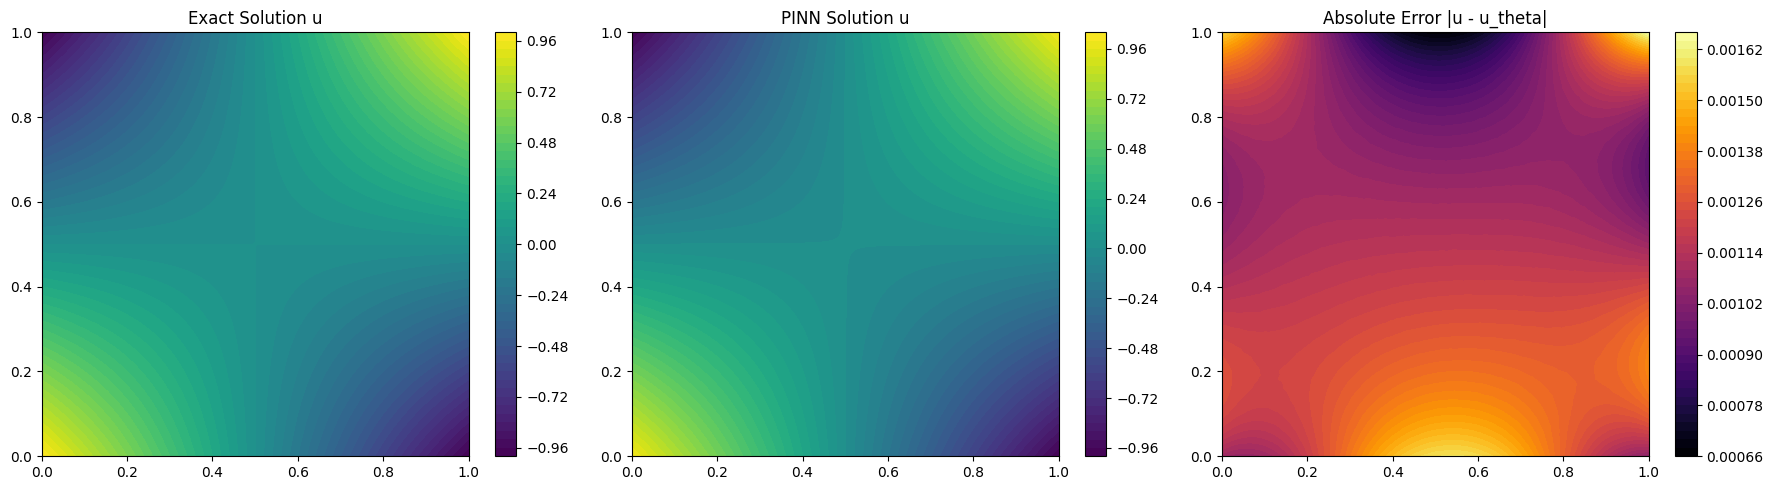

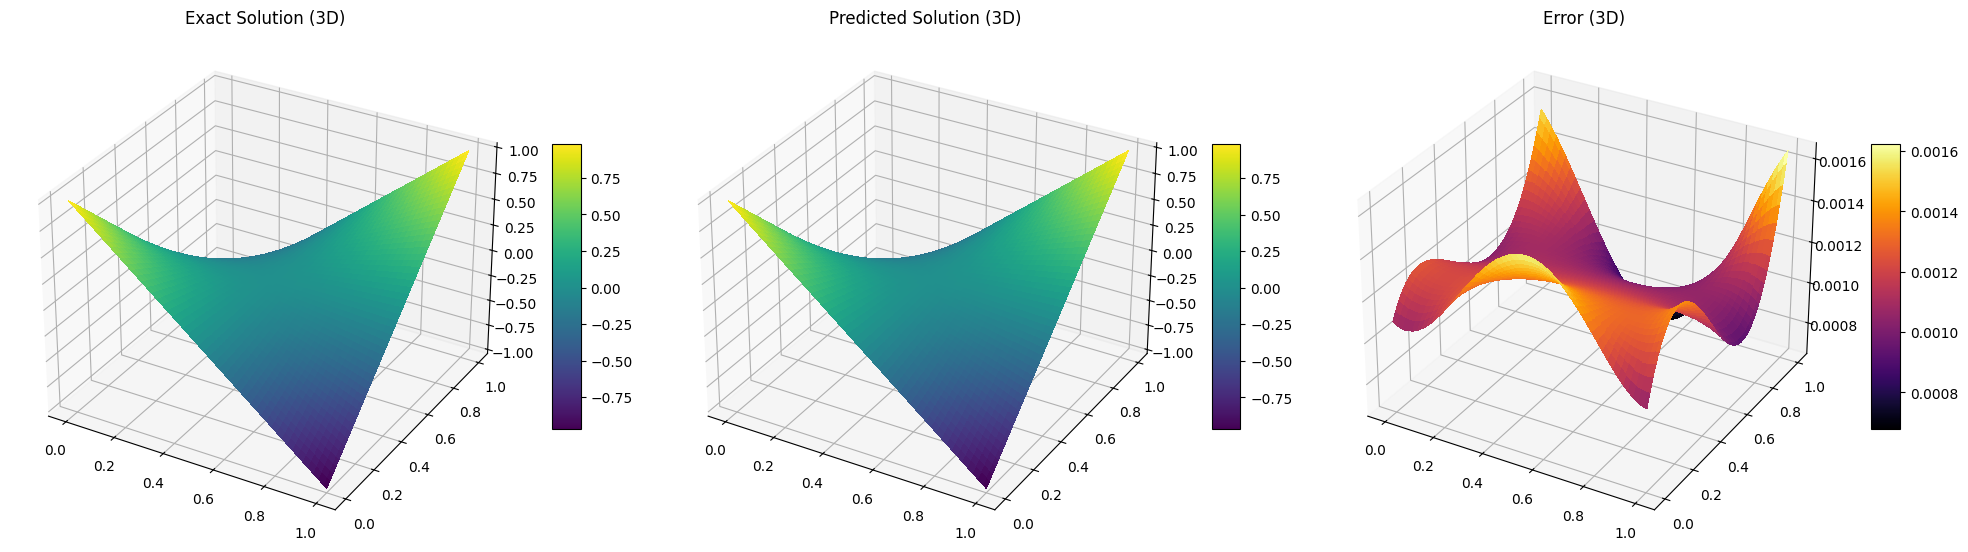

Plots generated: loss_history.png, 2d_contours.png, 3d_surfaces.png
Model saved to pinn_model_p4.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
import os

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ==========================================
# 1. Configuration & Parameters
# ==========================================
class Config:
    # Domain
    x_min, x_max = 0.0, 1.0
    y_min, y_max = 0.0, 1.0

    # Architecture
    layers = [2, 40, 40, 40, 40, 1] 
    activation = nn.Tanh()
    
    # Training 
    epochs_adam = 20000 
    lr_adam = 1e-3
    epochs_lbfgs = 5000 
    
    # Weights (Reverted to 1.0 to strictly follow PDF standard formulation)
    lambda_int = 1.0
    lambda_bc = 50.0 

config = Config()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==========================================
# 2. Exact Solution & Helper Functions
# ==========================================
def exact_u_func(x, y):
    """
    Example 2 : u = (2x - 1)(2y - 1)
    """
    return (2*x - 1) * (2*y - 1)

def exact_f_func(x, y):
    """
    Source term f = Delta^2 u
    For u = (2x-1)(2y-1), Delta u = 0 => Delta^2 u = 0
    """
    return torch.zeros_like(x)

# ==========================================
# 3. Neural Network Model
# ==========================================
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = layers
        self.linears = nn.ModuleList([
            nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)
        ])
        
        # Xavier Initialization
        for i in range(len(self.linears)):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
        self.activation = config.activation

    def forward(self, x):
        a = x
        for i in range(len(self.linears) - 1):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# ==========================================
# 4. Differential Operators (Pure Autograd)
# ==========================================
def get_derivatives(model, x_in):
    """
    Computes necessary derivatives using autograd.
    x_in: (N, 2) tensor requires_grad=True
    """
    u = model(x_in)
    
    # First derivatives (Gradient)
    grads = torch.autograd.grad(u, x_in, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = grads[:, 0:1]
    u_y = grads[:, 1:2]
    
    # Second derivatives (Laplacian & Hessian components)
    grads_x = torch.autograd.grad(u_x, x_in, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xx = grads_x[:, 0:1]
    
    # Mixed derivative for H2 error
    grads_y = torch.autograd.grad(u_y, x_in, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    u_yy = grads_y[:, 1:2]
    u_xy = grads_y[:, 0:1] 
    
    laplacian = u_xx + u_yy
    
    # Third derivatives (Gradient of Laplacian) - For P4 BCs
    grads_lap = torch.autograd.grad(laplacian, x_in, grad_outputs=torch.ones_like(laplacian), create_graph=True)[0]
    lap_x = grads_lap[:, 0:1]
    lap_y = grads_lap[:, 1:2]
    
    # Fourth derivatives (Biharmonic)
    grads_lap_x = torch.autograd.grad(lap_x, x_in, grad_outputs=torch.ones_like(lap_x), create_graph=True)[0]
    lap_xx = grads_lap_x[:, 0:1]
    
    grads_lap_y = torch.autograd.grad(lap_y, x_in, grad_outputs=torch.ones_like(lap_y), create_graph=True)[0]
    lap_yy = grads_lap_y[:, 1:2]
    
    # Delta^2 u
    biharmonic = lap_xx + lap_yy 
    
    return u, u_x, u_y, u_xx, u_yy, u_xy, laplacian, lap_x, lap_y, biharmonic

# ==========================================
# 5. Data Generation
# ==========================================
def generate_data():
    # Interior points
    x_int = np.random.uniform(config.x_min, config.x_max, (config.N_interior, 2))
    x_int_tensor = torch.tensor(x_int, dtype=torch.float32, requires_grad=True).to(device)
    
    # Boundary points setup
    n_side = config.N_boundary // 4
    
    # Bottom
    x_b = np.random.uniform(0, 1, (n_side, 1))
    y_b = np.zeros((n_side, 1))
    pts_bottom = np.hstack((x_b, y_b))
    n_bottom = np.tile([0.0, -1.0], (n_side, 1))
    
    # Top
    x_t = np.random.uniform(0, 1, (n_side, 1))
    y_t = np.ones((n_side, 1))
    pts_top = np.hstack((x_t, y_t))
    n_top = np.tile([0.0, 1.0], (n_side, 1))
    
    # Left
    x_l = np.zeros((n_side, 1))
    y_l = np.random.uniform(0, 1, (n_side, 1))
    pts_left = np.hstack((x_l, y_l))
    n_left = np.tile([-1.0, 0.0], (n_side, 1))
    
    # Right
    x_r = np.ones((n_side, 1))
    y_r = np.random.uniform(0, 1, (n_side, 1))
    pts_right = np.hstack((x_r, y_r))
    n_right = np.tile([1.0, 0.0], (n_side, 1))
    
    # Combine
    pts_all = np.vstack((pts_bottom, pts_top, pts_left, pts_right))
    n_all = np.vstack((n_bottom, n_top, n_left, n_right))
    
    pts_bc_tensor = torch.tensor(pts_all, dtype=torch.float32, requires_grad=True).to(device)
    n_bc_tensor = torch.tensor(n_all, dtype=torch.float32).to(device)
    
    return x_int_tensor, pts_bc_tensor, n_bc_tensor


# ==========================================
# 6. Loss Function (Problem P4)             
# ==========================================
def calculate_loss(model, x_int, x_bc, n_bc):
    # 1. Interior Loss
    # Need u_int to enforce zero mean (P4 requirement)
    u_int, _, _, _, _, _, _, _, _, biharmonic = get_derivatives(model, x_int)
    
    f_pred = biharmonic
    f_true = exact_f_func(x_int[:,0:1], x_int[:,1:2])
    
    # PDF P4 Interior Loss: |Delta^2 u - f|^2 + (mean(u))^2
    loss_pde = torch.mean((f_pred - f_true)**2)
    loss_zero_mean = (torch.mean(u_int))**2 
    loss_int = loss_pde + loss_zero_mean
    
    # 2. Boundary Loss
    x_b = x_bc[:, 0:1]
    y_b = x_bc[:, 1:2]
    nx = n_bc[:, 0:1]
    ny = n_bc[:, 1:2]
    
    # Exact g1 = du/dn
    # u = (2x-1)(2y-1) => ux = 2(2y-1), uy = 2(2x-1)
    exact_ux = 2 * (2*y_b - 1)
    exact_uy = 2 * (2*x_b - 1)
    g1_true = exact_ux * nx + exact_uy * ny
    
    # Exact g2 = d(Delta u)/dn 
    # Delta u = 0 => g2 = 0
    g2_true = torch.zeros_like(g1_true)
    
    # Predictions
    _, u_x_bc, u_y_bc, _, _, _, _, lap_x_bc, lap_y_bc, _ = get_derivatives(model, x_bc)
    
    # P4 Boundary Condition 1: du/dn = g1
    g1_pred = u_x_bc * nx + u_y_bc * ny
    
    # P4 Boundary Condition 2: d(Delta u)/dn = g2
    g2_pred = lap_x_bc * nx + lap_y_bc * ny
    
    loss_bc1 = torch.mean((g1_pred - g1_true)**2)
    loss_bc2 = torch.mean((g2_pred - g2_true)**2)
    loss_bc = loss_bc1 + loss_bc2
    
    total_loss = config.lambda_int * loss_int + config.lambda_bc * loss_bc
    return total_loss, loss_int, loss_bc

# ==========================================
# 7. Training
# ==========================================
def train():
    model = PINN(config.layers).to(device)
    optimizer_adam = optim.Adam(model.parameters(), lr=config.lr_adam)
    
    # LBFGS Optimizer
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(), 
        lr=1.0, 
        max_iter=config.epochs_lbfgs, 
        max_eval=config.epochs_lbfgs, 
        tolerance_grad=1e-7, 
        tolerance_change=1e-9, 
        history_size=50, 
        line_search_fn="strong_wolfe"
    )
    
    x_int, x_bc, n_bc = generate_data()
    loss_history = []
    start_time = time.time()
    
    print("Starting Adam optimization...")
    for epoch in range(config.epochs_adam):
        optimizer_adam.zero_grad()
        loss, l_int, l_bc = calculate_loss(model, x_int, x_bc, n_bc)
        loss.backward()
        optimizer_adam.step()
        
        loss_history.append(loss.item())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.2e} (Int: {l_int.item():.2e}, BC: {l_bc.item():.2e})")
            
    print("\nStarting LBFGS optimization...")
    def closure():
        optimizer_lbfgs.zero_grad()
        loss, l_int, l_bc = calculate_loss(model, x_int, x_bc, n_bc)
        loss.backward()
       
        return loss

    optimizer_lbfgs.step(closure)
    
    # Append final LBFGS loss
    final_loss, _, _ = calculate_loss(model, x_int, x_bc, n_bc)
    loss_history.append(final_loss.item())
    
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds.")
    print(f"Final Loss: {final_loss.item():.5e}")
    
    return model, loss_history, training_time

# ==========================================
# 8. Error Analysis
# ==========================================
def compute_errors(model):
    n_grid = 100
    x = np.linspace(0, 1, n_grid)
    y = np.linspace(0, 1, n_grid)
    X, Y = np.meshgrid(x, y)
    pts = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
    pts_tensor = torch.tensor(pts, dtype=torch.float32, requires_grad=True).to(device)
    
    u_pred, u_x, u_y, u_xx, u_yy, u_xy, _, _, _, _ = get_derivatives(model, pts_tensor)
    
    u_pred = u_pred.detach().cpu().numpy()
    u_x = u_x.detach().cpu().numpy()
    u_y = u_y.detach().cpu().numpy()
    u_xx = u_xx.detach().cpu().numpy()
    u_yy = u_yy.detach().cpu().numpy()
    u_xy = u_xy.detach().cpu().numpy()
    
    # Exact values
    u_exact = exact_u_func(pts[:,0:1], pts[:,1:2])
    ux_exact = 2 * (2*pts[:,1:2] - 1)
    uy_exact = 2 * (2*pts[:,0:1] - 1)
    uxx_exact = np.zeros_like(u_exact)
    uyy_exact = np.zeros_like(u_exact)
    uxy_exact = 4 * np.ones_like(u_exact)
    
    # L2 Relative Error
    err_sq = (u_exact - u_pred)**2
    l2_err = np.sqrt(np.mean(err_sq))
    l2_norm = np.sqrt(np.mean(u_exact**2))
    l2_rel = l2_err / l2_norm
    
    # GRADIENT ERRORS FOR H1 NORM - H1 Relative error
    grad_err_sq = (ux_exact - u_x)**2 + (uy_exact - u_y)**2
    h1_err = np.sqrt(np.mean(err_sq + grad_err_sq))
    h1_norm = np.sqrt(np.mean(u_exact**2 + ux_exact**2 + uy_exact**2))
    h1_rel = h1_err / h1_norm
    
    # HESSIAN ERRORS FOR H2 NORM -H2 Relative error
    hess_err_sq = (uxx_exact - u_xx)**2 + (uyy_exact - u_yy)**2 + 2*(uxy_exact - u_xy)**2
    h2_err = np.sqrt(np.mean(err_sq + grad_err_sq + hess_err_sq))
    h2_norm = np.sqrt(np.mean(u_exact**2 + ux_exact**2 + uy_exact**2 + uxx_exact**2 + uyy_exact**2 + 2*uxy_exact**2))
    h2_rel = h2_err / h2_norm
    
    return (l2_err, h1_err, h2_err), (l2_rel, h1_rel, h2_rel), X, Y, u_pred.reshape(n_grid, n_grid), u_exact.reshape(n_grid, n_grid)

# ==========================================
# 9. Plotting
# ==========================================
def plot_results(loss_hist, X, Y, u_pred, u_exact):
    # 1. Loss History
    plt.figure(figsize=(8, 6))
    plt.semilogy(loss_hist)
    plt.title("Loss History (Training Dynamics)")
    plt.xlabel("Adam Iterations + Final LBFGS Step")
    plt.ylabel("Loss")
    plt.grid(True, which='both')
    plt.savefig("loss_history.png")
    plt.show()

    # 2. 2D Contours
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    # Exact
    c1 = ax[0].contourf(X, Y, u_exact, levels=50, cmap='viridis')
    ax[0].set_title("Exact Solution u")
    plt.colorbar(c1, ax=ax[0])
    
    # Computed - predicted
    c2 = ax[1].contourf(X, Y, u_pred, levels=50, cmap='viridis')
    ax[1].set_title("PINN Solution u")
    plt.colorbar(c2, ax=ax[1])
    
    # Absolute Error
    err = np.abs(u_exact - u_pred)
    c3 = ax[2].contourf(X, Y, err, levels=50, cmap='inferno')
    ax[2].set_title("Absolute Error |u - u_theta|")
    plt.colorbar(c3, ax=ax[2])
    
    plt.tight_layout()
    plt.savefig("2d_contours.png")
    plt.show()
    
    # 3. 3D SURFACE PLOTS OF EXACT, PREDICTED, AND ERROR
    fig = plt.figure(figsize=(20, 6))
    
    # Exact 3D 
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X, Y, u_exact, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax1.set_title("Exact Solution (3D)")
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)
    
    # Predicted 3D
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X, Y, u_pred, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax2.set_title("Predicted Solution (3D)")
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)
    
    # Error 3D
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(X, Y, err, cmap=cm.inferno, linewidth=0, antialiased=False)
    ax3.set_title("Error (3D)")
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10)
    
    plt.tight_layout()
    plt.savefig("3d_surfaces.png")
    plt.show()

# ==========================================
# Main Execution
# ==========================================
if __name__ == "__main__":
    print("Starting PINN training for Biharmonic Problem P4...")
    
    # Train
    model, loss_history, train_time = train()
    
    # Compute Errors
    abs_errs, rel_errs, X, Y, u_pred, u_exact = compute_errors(model)
    
    # TOTAL NUMBER OF NONZERO PARAMETERS (n_L)
    n_params = model.count_parameters()
    
    print("\n" + "="*40)
    print("RESULTS SUMMARY")
    print("="*40)
    print(f"Computation Time: {train_time:.4f} seconds")
    print(f"Network Architecture: {config.layers}")
    print(f"Total Non-zero Parameters: {n_params}")
    print("-" * 40)
    print("ERRORS (Absolute | Relative)")
    print(f"L2 Error: {abs_errs[0]:.4e}  |  {rel_errs[0]:.4e}")
    print(f"H1 Error: {abs_errs[1]:.4e}  |  {rel_errs[1]:.4e}")
    print(f"H2 Error: {abs_errs[2]:.4e}  |  {rel_errs[2]:.4e}")
    print("="*40)
    
    # Plot
    plot_results(loss_history, X, Y, u_pred, u_exact)
    print("Plots generated: loss_history.png, 2d_contours.png, 3d_surfaces.png")
    
    # SAVE TRAINED MODEL FOR FUTURE USE / PLOTTING
    save_path = "pinn_model_p4.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")